### Burgers' equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In Maziar Raissi, Paris Perdikaris, and George Em Karniadakis paper: <br>
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} -\frac{0.01}{\pi} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$ <br>
$$u(0,x) = -sin(\pi x) \textrm{, which is the initial condition}$$ <br>
$$u(t,-1) = u(t,1) = 0 \textrm{, which is the Dirichlet boundary conditions}$$<br>
$$x \in [-1,1], \textrm{ }t\in [0,1]$$
Close to the exact solution is $u(t,x) = e^{-t}sin(\pi x)$, [here is the exact analytical solution.](https://www.sciencedirect.com/science/article/abs/pii/0045793086900368)

The loss is defined by: $MSE = MSE_f + MSE_u$, it is a combination of the PDE loss $MSE_f$ and the boundary & initial conditions loss $MSE_u$. <br>
$MSE_f = \frac{1}{N_f}\Sigma_{i=1}^{N_f} |f(t_f^i,x_f^i)|^2$, where $\{t_f^i,x_f^i\}_{i=1}^{N_f}$ is the grid generated for the PDE (collocations points = points where we test the function $f$). <br>
$MSE_u = \frac{1}{N_u}\Sigma_{i=1}^{N_u} |u(t_u^i,x_u^i) - u^i|^2$, where $\{t_u^i,x_u^i\}_{i=1}^{N_u}$ is the grid generated for the boundary & initial conditions, ```u^i``` is an exact solution point from the boundary and initial conditions, ```u(t_u^i,x_u^i)``` is an approximation of $u(t,x)$ (the exact solution) given by the PINN.

In inference, we are looking to find the exact solution of the PDE (partial derivate equation), $u(t,x)$. The PDE, boundary and inital conditions are known, $u(t,x)$ is unknown. We want to solve the true PDE without knowing its solution, it can be seen as an unsupervised task where the data required is only the boundary and initial conditions (t = 0, x = -1, 1)).

### DNN

In [1]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [2]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, lambda_1, lambda_2, xt_train, xt_f, u_train, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"xt_f shape: {xt_f.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the x
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the t
        self.x_f = torch.tensor(xt_f[:, 0:1], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the x
        self.t_f = torch.tensor(xt_f[:, 1:2], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the t
        self.u_tr = torch.tensor(u_train).float().to(self.device) #100, 1; exact solution for the 100 random ic/bc pairs
        self.lambda_1 = lambda_1 
        self.lambda_2 = lambda_2 
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 1
        
    def net_u(self, x, t): #get u(x,t) for a pair (x,t); a forward pass through the PINN
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t): #get f = u_t + u * u_x - self.nu * u_xx; the true u(x,t) makes f = 0
        u = self.net_u(x, t)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t + self.lambda_1 * u * u_x - self.lambda_2 * u_xx #the computed PDE, we want to be a close as possible to 0
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr) #100, 1; all the ic/bc pairs were feeded through the PINN
        f_pred = self.net_f(self.x_f, self.t_f) #10456, 1; all the collocations points were feeded through the PINN
        
        loss_u = torch.mean((self.u_tr - u_pred) ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [3]:
import numpy as np
import scipy.io
from pyDOE import lhs
import time

Nu = 100
Nf = 10000
lambda_1 = 1
lambda_2 = 0.01/np.pi

sol_data = scipy.io.loadmat('burgers_shock.mat')
t_sol = sol_data['t'].flatten()[:,None] #100,1
x_sol = sol_data['x'].flatten()[:,None] #256,1
X, T = np.meshgrid(x_sol,t_sol) #X 100,256; T 100,256
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #25600, 2, exact solution input pairs (t,x)
lower_bound_domain = xt_sol.min(0) #(xmin, tmin)
upper_bound_domain = xt_sol.max(0)
U_sol = np.real(sol_data['usol']).T #256,100
u_sol = U_sol.flatten()[:,None] #25600, 1, exact solution u(t,x)             

xt_ic = np.hstack((X[0:1,:].T, T[0:1,:].T))
u_ic = -np.sin(xt_ic[:,0:1]*np.pi)
xt_bc1 = np.hstack((X[:,0:1], T[:,0:1])) #100, 2; correspond to the first boundary condition u(t,x=-1) = 0
u_bc1 = np.zeros(xt_bc1[:,0:1].shape)
xt_bc2 = np.hstack((X[:,-1:], T[:,-1:])) #100, 2; corresponds to the second boundary condition u(t,x=1) = 0
u_bc2 = np.zeros(xt_bc2[:,0:1].shape)

xt_train = np.vstack([xt_ic, xt_bc1, xt_bc2])
xt_train_reserve = xt_train
u_train = np.vstack([u_ic, u_bc1, u_bc2])
u_train_reserve = u_train

def gen_train_data(Nu, Nf, lb, ub, xt_tr, u):
    xt_f = lb + (ub - lb) * lhs(2, Nf)
    xt_f = np.vstack((xt_f, xt_tr)) 
    idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
    xt_train = xt_tr[idx, :]
    u_train = u[idx, :]
    return xt_train, xt_f, u_train

#data generation without burgers_shock.mat
def gen_train_data_2(Nu, Nf, lb, ub): 
    x_rand = np.random.uniform(low=lb[0], high=ub[0], size=(Nu*2,1))
    t_rand = np.random.uniform(low=lb[1], high=ub[1], size=(Nu,1))
    xt_ic = np.vstack([x_rand[:,0], np.zeros(x_rand[:,0].shape)]).T
    u_ic = (-np.sin(x_rand*np.pi)).reshape(-1,1)
    xt_bc1 = np.vstack([np.ones(t_rand[:,0].shape) * -1, t_rand[:,0]]).T
    u_bc1 = np.zeros(t_rand.shape)
    xt_bc2 = np.vstack([np.ones(t_rand[:,0].shape), t_rand[:,0]]).T
    u_bc2 = np.zeros(t_rand.shape)
    u_tr = np.vstack([u_ic, u_bc1, u_bc2])
    
    xt_tr = np.vstack([xt_ic, xt_bc1, xt_bc2])
    u_tr = np.vstack([u_ic, u_bc1, u_bc2])
    
    xt_f = lb + (ub - lb) * lhs(2, Nf)
    xt_f = np.vstack((xt_f, xt_tr)) 
    
    idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
    xt_tr = xt_tr[idx, :]
    u_tr = u_tr[idx, :]
    return xt_tr, xt_f, u_tr

xt_train, xt_f, u_train = gen_train_data(Nu, Nf, lower_bound_domain, upper_bound_domain, xt_train, u_train)
#xt_train, xt_f, u_train = gen_train_data2(Nu, Nf, lower_bound_domain, upper_bound_domain)

### Create and train

In [4]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

#model = PINN(layers, lambda_1, lambda_2, xt_train, xt_f, u_train)
model = PINN(layers, lambda_1, lambda_2, xt_train, xt_f, u_train, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (100, 2)
xt_f shape: (10456, 2)
u_train shape: (100, 1)
Iter 100, Loss: 8.05679e-02, Loss_u: 5.58158e-02, Loss_f: 2.47521e-02
Iter 200, Loss: 4.51533e-02, Loss_u: 2.71722e-02, Loss_f: 1.79812e-02
Iter 300, Loss: 1.96026e-02, Loss_u: 8.82000e-03, Loss_f: 1.07826e-02
Iter 400, Loss: 9.82149e-03, Loss_u: 4.10445e-03, Loss_f: 5.71704e-03
Iter 500, Loss: 5.17654e-03, Loss_u: 1.49553e-03, Loss_f: 3.68101e-03
Iter 600, Loss: 2.35136e-03, Loss_u: 7.62290e-04, Loss_f: 1.58907e-03
Iter 700, Loss: 1.23187e-03, Loss_u: 3.56391e-04, Loss_f: 8.75483e-04
Iter 800, Loss: 7.63666e-04, Loss_u: 2.69155e-04, Loss_f: 4.94511e-04
Iter 900, Loss: 5.43561e-04, Loss_u: 1.26069e-04, Loss_f: 4.17492e-04
Iter 1000, Loss: 3.45265e-04, Loss_u: 8.55961e-05, Loss_f: 2.59669e-04
Iter 1100, Loss: 2.79444e-04, Loss_u: 6.29202e-05, Loss_f: 2.16523e-04
Iter 1200, Loss: 2.23587e-04, Loss_u: 4.99499e-05, Loss_f: 1.73637e-04
Iter 1300, Loss: 1.90001e-04, Loss_u: 3.98072e-05, Loss_f: 1.5019

### Evaluate

In [5]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred_tr, f_pred_tr = model.predict(xt_train)

l2_u_tr = l2_norm(u_pred_tr, u_train)  
mse_u_tr = mse(u_pred_tr, u_train)
mse_f_tr = mse(f_pred_tr, np.zeros(f_pred_tr.shape))

u_pred_te, f_pred_te = model.predict(xt_sol)

l2_u_te = l2_norm(u_pred_te, u_sol)  
mse_u_te = mse(u_pred_te, u_sol)
mse_f_te = mse(f_pred_te, np.zeros(f_pred_te.shape))


print(f'Train L2 Error u: %e' % (l2_u_tr))
print(f'Test L2 Error u: %e' % (l2_u_te)) 
print(f'Train MSE Error u: %e' % (mse_u_tr))
print(f'Test MSE Error u: %e' % (mse_u_te))
print(f'Train MSE Error f: %e' % (mse_f_tr)) 
print(f'Test MSE Error f: %e' % (mse_f_te)) 

Train L2 Error u: 6.883168e-04
Test L2 Error u: 1.177460e-03
Train MSE Error u: 1.354367e-07
Test MSE Error u: 5.232465e-07
Train MSE Error f: 5.301306e-06
Test MSE Error f: 5.971424e-06


### Plot

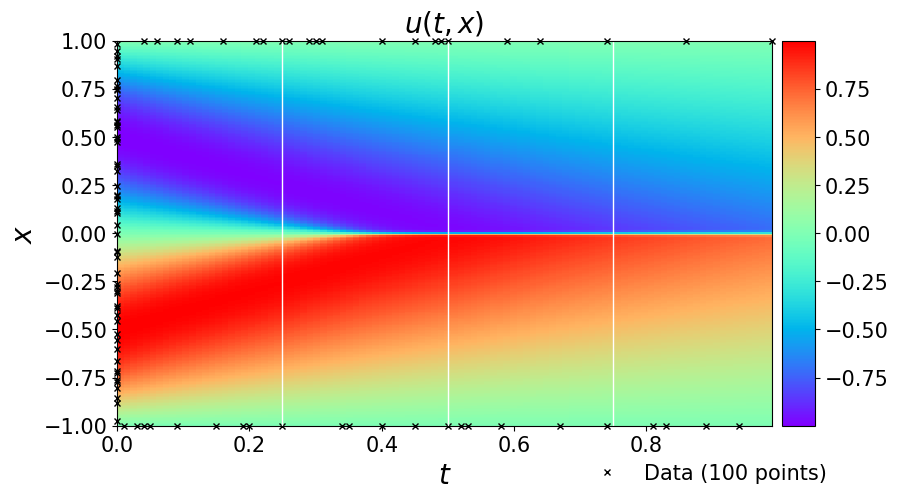

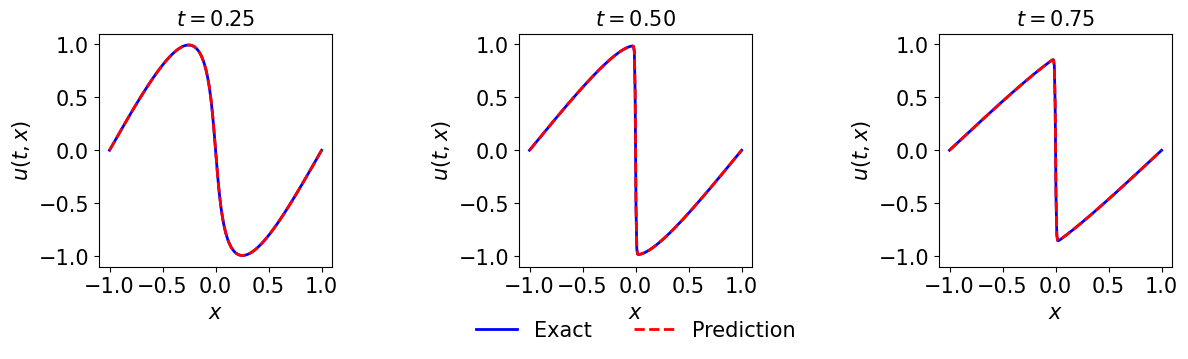

In [6]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred_te.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_sol.min(), t_sol.max(), x_sol.min(), x_sol.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1], 
    xt_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_sol.min(), x_sol.max(), 2)[:,None]
ax.plot(t_sol[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_sol[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_sol,U_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_sol,U_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_sol,U_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_sol,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Network architecture comparison

In [7]:
%%time

nb_neurons = [10, 20, 40]
nb_hidden_layers = [2, 4, 6, 8, 10]


L2_u_1 = list()
MSE_u_1 = list()
MSE_f_1 = list()

for i in range(len(nb_hidden_layers)):
    for j in range(len(nb_neurons)):
        layers = np.hstack([np.array([2]),np.full(nb_hidden_layers[i], nb_neurons[j]),np.array([1])])
        #verbose = False
        model = PINN(layers, lambda_1, lambda_2, xt_train, xt_f, u_train, tol = 1e-5, hs = 50, verbose = False)
        model.train()
        
        u_pred_tr, f_pred_tr = model.predict(xt_train)
        u_pred_te, f_pred_te = model.predict(xt_sol)
        
        L2_u_1.append(l2_norm(u_pred_te, u_sol))
        MSE_u_1.append(mse(u_pred_te, u_sol))
        MSE_f_1.append(mse(f_pred_te, np.zeros(f_pred_te.shape)))
        
        print('l: %d, n: %d, MSE_u_tr: %.2e, MSE_f_tr: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e' % (nb_hidden_layers[i], nb_neurons[j], mse(u_pred_tr, u_train), mse(f_pred_tr, np.zeros(f_pred_tr.shape)), MSE_u_1[-1], MSE_f_1[-1]))
        

best_idx = np.argmin(L2_u_1)
best_nb_layers, best_nb_neurons = np.unravel_index(best_idx, (len(nb_hidden_layers),len(nb_neurons)))

print("\n")

print('Best test perf l: %d, n: %d, l2_u_te: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e' % (nb_hidden_layers[best_nb_layers], nb_neurons[best_nb_neurons], L2_u_1[best_idx], MSE_u_1[best_idx], MSE_f_1[best_idx]))

"""
print("\n")
print("L2_u_test:")
for i in L2_u_1:
    print(i)"""

l: 2, n: 10, MSE_u_tr: 2.80e-03, MSE_f_tr: 3.16e-03, MSE_u_te: 8.63e-03, MSE_f_te: 4.30e-03
l: 2, n: 20, MSE_u_tr: 3.87e-04, MSE_f_tr: 3.64e-04, MSE_u_te: 1.39e-03, MSE_f_te: 8.32e-04
l: 2, n: 40, MSE_u_tr: 1.72e-04, MSE_f_tr: 2.65e-04, MSE_u_te: 3.50e-03, MSE_f_te: 5.48e-04
l: 4, n: 10, MSE_u_tr: 2.15e-05, MSE_f_tr: 1.18e-04, MSE_u_te: 9.52e-05, MSE_f_te: 1.52e-04
l: 4, n: 20, MSE_u_tr: 1.33e-05, MSE_f_tr: 5.11e-05, MSE_u_te: 2.59e-04, MSE_f_te: 7.18e-05
l: 4, n: 40, MSE_u_tr: 2.78e-06, MSE_f_tr: 1.29e-05, MSE_u_te: 3.01e-05, MSE_f_te: 1.55e-05
l: 6, n: 10, MSE_u_tr: 7.12e-06, MSE_f_tr: 6.17e-05, MSE_u_te: 9.66e-06, MSE_f_te: 6.68e-05
l: 6, n: 20, MSE_u_tr: 8.62e-07, MSE_f_tr: 2.20e-05, MSE_u_te: 1.87e-05, MSE_f_te: 2.44e-05
l: 6, n: 40, MSE_u_tr: 5.97e-07, MSE_f_tr: 8.13e-06, MSE_u_te: 6.30e-07, MSE_f_te: 1.53e-05
l: 8, n: 10, MSE_u_tr: 3.53e-07, MSE_f_tr: 1.31e-05, MSE_u_te: 1.27e-06, MSE_f_te: 1.53e-05
l: 8, n: 20, MSE_u_tr: 1.34e-05, MSE_f_tr: 1.60e-04, MSE_u_te: 4.00e-05, MSE_f_t

'\nprint("\n")\nprint("L2_u_test:")\nfor i in L2_u_1:\n    print(i)'

### Data size comparison

In [8]:
%%time

Nu = [10, 50 , 100, 200]
Nf = [1000, 2000, 5000, 10000]

L2_u_2 = list()
MSE_u_2 = list()
MSE_f_2 = list()
neurons_per_layer = 20
hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(hidden_layers, neurons_per_layer),np.array([1])])

for i in range(len(Nu)):
    for j in range(len(Nf)):
        xt_train_, xt_f_, u_train_ = gen_train_data(Nu[i], Nf[j], lower_bound_domain, upper_bound_domain, xt_train_reserve, u_train_reserve)
        #verbose = False
        model = PINN(layers, lambda_1, lambda_2, xt_train_, xt_f_, u_train_, tol=1e-5, hs=50, verbose=False)
        model.train()
        
        u_pred_tr, f_pred_tr = model.predict(xt_train_)
        u_pred_te, f_pred_te = model.predict(xt_sol)
        
        L2_u_2.append(l2_norm(u_pred_te, u_sol))
        MSE_u_2.append(mse(u_pred_te, u_sol))
        MSE_f_2.append(mse(f_pred_te, np.zeros(f_pred_te.shape)))

        print('Nu: %d, Nf: %d, MSE_u_tr: %.2e, MSE_f_tr: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e' % (Nu[i], Nf[j], mse(u_pred_tr, u_train_), mse(f_pred_tr, np.zeros(f_pred_tr.shape)), MSE_u_2[-1], MSE_f_2[-1]))

        
best_idx = np.argmin(L2_u_2)
best_nu, best_nf = np.unravel_index(best_idx, (len(Nu),len(Nf)))

print("\n")

print('Best test perf Nu: %d, Nf: %d, l2_u_te: %.2e, MSE_u_te: %.2e, MSE_f_te: %.2e' % (Nu[best_nu], Nf[best_nf], L2_u_2[best_idx], MSE_u_2[best_idx], MSE_f_2[best_idx]))

"""
print("\n")
print("L2_u_test:")
for i in L2_u_2:
    print(i)"""

Nu: 10, Nf: 1000, MSE_u_tr: 2.04e-08, MSE_f_tr: 1.98e-06, MSE_u_te: 9.81e-02, MSE_f_te: 1.48e-01
Nu: 10, Nf: 2000, MSE_u_tr: 9.91e-09, MSE_f_tr: 3.42e-06, MSE_u_te: 2.81e-01, MSE_f_te: 4.49e-06
Nu: 10, Nf: 5000, MSE_u_tr: 2.18e-08, MSE_f_tr: 7.29e-06, MSE_u_te: 5.14e-01, MSE_f_te: 2.53e-06
Nu: 10, Nf: 10000, MSE_u_tr: 2.65e-07, MSE_f_tr: 3.80e-05, MSE_u_te: 6.94e-02, MSE_f_te: 3.62e-06
Nu: 50, Nf: 1000, MSE_u_tr: 3.38e-06, MSE_f_tr: 1.11e-05, MSE_u_te: 7.13e-02, MSE_f_te: 6.74e-01
Nu: 50, Nf: 2000, MSE_u_tr: 2.91e-07, MSE_f_tr: 1.35e-06, MSE_u_te: 3.98e-02, MSE_f_te: 2.05e-01
Nu: 50, Nf: 5000, MSE_u_tr: 6.74e-07, MSE_f_tr: 9.36e-06, MSE_u_te: 1.13e-04, MSE_f_te: 3.84e-05
Nu: 50, Nf: 10000, MSE_u_tr: 9.96e-07, MSE_f_tr: 2.08e-05, MSE_u_te: 2.44e-05, MSE_f_te: 4.33e-05
Nu: 100, Nf: 1000, MSE_u_tr: 1.62e-05, MSE_f_tr: 9.38e-06, MSE_u_te: 5.19e-02, MSE_f_te: 3.05e+00
Nu: 100, Nf: 2000, MSE_u_tr: 9.83e-08, MSE_f_tr: 1.12e-06, MSE_u_te: 9.46e-06, MSE_f_te: 4.81e-04
Nu: 100, Nf: 5000, MSE_u_t

'\nprint("\n")\nprint("L2_u_test:")\nfor i in L2_u_2:\n    print(i)'